# Introduction to transformers


<script async defer src="https://buttons.github.io/buttons.js"></script>
<a class="github-button" href="https://github.com/stratisMarkou/random-walks" data-color-scheme="no-preference: light; light: light; dark: dark;" data-icon="octicon-star" data-size="large" aria-label="Star stratisMarkou/random-walks on GitHub" style="float: right;">Star</a>
<a class="github-button" href="https://github.com/stratisMarkou/random-walks/issues" data-color-scheme="no-preference: light; light: light; dark: dark;" data-icon="octicon-issue-opened" data-size="large" aria-label="Issue stratisMarkou/random-walks on GitHub">Issue</a>
<a class="github-button" href="https://github.com/stratisMarkou/random-walks/subscription" data-color-scheme="no-preference: light; light: light; dark: dark;" data-icon="octicon-eye" data-size="large" aria-label="Watch stratisMarkou/random-walks on GitHub">Watch</a>
<a class="github-button" href="https://github.com/stratisMarkou" data-color-scheme="no-preference: light; light: light; dark: dark;" data-size="large" aria-label="Follow @stratisMarkou on GitHub">Follow</a>

The transformer {cite}`vaswani2017attention` is a deep learning architecture which has powered many of the recent advances across a range of machine learning applications, including text modelling, image modelling {cite}`dosovitskiy2021image`, and many others.
This is an overview of the transformer architecture, including a self-contained mathematical description of the architectural details, and a concise implementation.
All of this exposition is based off an excellent introduction paper on transformers by Rich Turner {cite}`turner2023introduction`.

## Modelling with tokens
__One architecture, many applications.__
The purpose of the transformer architecture was, originally, to model sequence data such as text.
The approach for achieving this was to first convert individual words, or characters, into one-dimensional arrays called _tokens_, and then operate on these tokens with a neural network.
This approach however extends beyond word modelling.
For example, the transformer can be applied to tasks as diverse as modelling of images and video, proteins, or weather.
In all these applications, the data are first converted into sets of tokens.
After this step, the transformer can be applied in roughly the same way, irrespective of the original representation of the data.
This versatility, together with their empirical performance, are some of the main appealing features of the transformer.

__Inputs as tokens.__
In particular, for the moment, we will assume that the input data have already been converted into tokens and defer the details of this tokenisation for later.
More concretely, let us assume that each data example, e.g. a sentence, image, or protein,  has been conerted into a set of tokens $\{x_n\}_{n=1}^N,$ where each $x_n$ is a $D$ dimensional array $x_n \in \mathbb{R}^D.$
We can collect these tokens into a single $D \times N$ array $X^{(0)} \in \mathbb{R}^{D \times N},$ forming a single data input for the transformer.

## Transformer block
Much like in other deep architectures, the transformer maintains a representation of the input data, and progressively refines it using a sequence of so-called _transformer blocks_.
In particular, given an initial representation $X^{(0)}$ the archtecture comprises of $M$ transformer blocks, i.e. for each $m = 1, \dots, M,$ it computes

$$X^{(m)} = \texttt{TransformerBlock}(X^{(m-1)}).$$

Each of these blocks consists of two main operations, namely a self-attention operation and a token-wise multi-layer perceptron (MLP) operation.
The self-attention operation has the role of combining the representations of different tokens in a sequence, in order to model dependencies between the tokens.
It is applied collectively to all tokens within the transformer block.
The MLP operation has the role of refining the representation of each token.
It is applied separately to each token and is shared across all tokens within a transformer block.
Let's look at these two operations in detail.

### Self-attention

__Attention.__
The role of the first operation in a transformer block is to combine the representations of different tokens in order to model dependencies between them.
Given a $D \times N$ input array $X^{(m)} = (x_1, \dots, x_N^{(m)})$ the output of the self-attention layer is another $D \times N$ array $Y^{(m)} = (y_1, \dots, y_N^{(m)}),$ where each column is simply a weighted average of the input features, that is

$$
y^{(m)}_n = \sum_{n' = 1}^N x^{(m - 1)}_{n'} A_{n', n}^{(m)}.
$$ (papers:eq:attention:sum)

```{margin}
__Relation to CNNs:__
If we constrain the weights to have a single index that depends on the difference of $n$ and $n',$ i.e. to have the form $A_{n', n}^{(m)} = A_{n'-n}^{(m)},$ then the sum in equation {eq}`papers:eq:attention:sum` can be viewed as a convolution with zero padding.
One difference to standard CNNs is that their convolutions are local, meaning they have a limited kernel size and do not see the entire input, whereas here we would have a kernel that sees the entire input, i.e. $y^{(m)}_n$ would depend on all of the $x^{(m - 1)}_{n'}.$
Another important difference to standard CNNs is that the weights do not depend on the inputs $x^{(m - 1)}_n,$ whereas in a transformer they do.
This is gives significant additional flexibility to the transformer architecture.
```
The weighting array $A_{n', n}^{(m)}$ is of size $N \times N$ and has the property that its columns normalise to one, that is $\sum_{n'=1}^N A_{n', n}^{(m)} = 1.$
It is referred to the attention matrix because it weighs the extent to which the feature $y^{(m)}_n$ should depend on each $x^{(m)}_{n'},$ i.e. it determines the extent to which each $y^{(m)}_n$ should attend to each $x^{(m)}_{n'}.$
For compactness, we can collect these equations to a single linear operation, that is

$$Y^{(m)} = X^{(m - 1)} A^{(m)}.$$

But what about the attention weights themselves?
We have not specified how these are computed and, their precise definition is going to be one important factor that differentiates transformers from other architectures.
In fact, many other operations forming the core of other archictectures, such as convolution layers in convolutional neural networks (CNNs), can be written as similar weighted sums.
Let's next look at the specifics of the transformer attention weights.

__Self-attention.__
One of the innovations within the transformer architecture is that the attention weights are adaptive, meaning that they are computed based on the input itself.
This is in contrast with other deep learning architectures such CNNs, where weighted sums are also used, but these weights are fixed and shared across all inputs.
One straightforward way to compute attention weights would be to compare them by a simple similarity metric, such as an inner product.
For example, given two tokens $x_i$ and $x_j,$ we can compute a dot-product between them, which acts as a similarity metric, exponetiate the result to make it positive and then normalise the result to ensure that each column sums to one, that is

$$A^{(m)}_{n, n'} = \frac{\exp(x_n^\top x_{n'})}{\sum_{n'' = 1}^N \exp(x_{n''}^\top x_{n'})}.$$

An alternative, slightly more flexible approach is to transform each token in the sequence by a linear map, say by applying a matrix $U \in \mathbb{R}^{K \times D}$ to each token first, that is

$$A^{(m)}_{n, n'} = \frac{\exp(x_n^\top U^\top U x_{n'})}{\sum_{n'' = 1}^N \exp(x_{n''}^\top U^\top U x_{n'})}.$$

This allows the tokens to be compared in a different space.
For example, if $K < D$ this approach automatically projects out some of the components of the tokens, comparing them in a lower-dimensional space.
However, this approach still has an important limitation, namely symmetry.
Specifically, the attention matrix above would be symmetric, which means that any two tokens would attend to each other with equal strengths.
This might be undesirable because, for example, we could imagine that one token might be important for informing the representation of another token, but not the other way around.
To address this, we can apply different linear operations, say $U_k$ and $U_q$ to each of the tokens being compared, and instead compute

$$A^{(m)}_{n, n'} = \frac{\exp(x_n^\top U_k^\top U_q x_{n'})}{\sum_{n'' = 1}^N \exp(x_{n''}^\top U_k^\top U_q x_{n'})}.$$

In this way, the resulting attention matrix that is not necessarily symmetric and an overall more expressive architecture.
Tokens no longer have to attend to each other with the same strength.
This weighting is known as self-attention, since each token in the sequence attends to every other token of the same sequence.
It is also possible to generalise this to attention between different sequences, which might be useful for some applications such as, for example joint modelling of text and images.
This generalisation is called cross-attention, and we defer its discussion for later.

__Multi-head self-attention.__
In order to increase the capacity of the self-attention layer, the transformer block includes $H$ separate self-attention operations with different parameters, in parallel.
The results of these operations are then projected down to a single $D \times N$ array again, which is required for further processing.
In particular, we have

```{margin}
As a recap to the notation in these equations: the $m$ superscript runs from $1$ to $M$ and is the index of the transformer block, the $n, n'$ and $n''$ superscripts run from $1$ to $N$ and index the tokens in the sequence within the current block, the $h$ subscript runs from $1$ to $H$ and denotes a particular self-attention head in the block.
Finally the $k$ and $q$ subscripts are not indices, but symbols distinguishing the two different kinds of matrices $U_k$ and $U_q.$
```

$$\begin{align}
Y^{(m)} = \texttt{MHSA}(X^{(m - 1)}) &= \sum^H_{h = 1} V_h^{(m)} X^{(m - 1)} A_h^{(m)}, \text{ where } \\
\left[A^{(m)}_h\right]_{n, n'} &= \frac{\exp\left(k_{h, n}^{(m)\top} q_{h, n'}^{(m)}\right)}{\sum_{n'' = 1}^N \exp\left(k_{h, n''}^{(m)\top} q_{h, n'}^{(m)}\right)} 
\end{align}$$


```{margin}
Note that the matrices $U_{h, k},$ $U_{h, k}$ and $V_h$ correspond to the key, query and value matrices in the standard exposition of transformers.
Here we have taken a bottom-down approach without introducing these terms, but use this notation to make the relationship to the standard exposition clear.
```
where $q_{h, n}^{(m)} = U^{(m)}_{q, h} x_n^{(m-1)}$ and $k_{h, n}^{(m)} = U^{(m)}_{k, h} x_n^{(m-1)}.$
At this point we should note that, due to the nonlinearity of $A^{(m)},$ together with the multiplication by $V^{(m)}_h$ and summation across $h,$ multi-head cross attention performs not just inter-feature but also intra-feature processing, i.e. each token interacts with and changes its own representation.
However, the capacity of this intra-feature processing is limited, and it is the job of the second stage, the MLP, to address this.
Let's next look at the MLP stage.

## Multi-layer perceptron
The self-attention layer has the role of aggregating information across tokens in a sequence to model joint dependencies.
In order to refine the representations themselves, a simple MLP is applied to each token in isolation, in a relatively simple step

$$x^{(m)}_n = \texttt{MLP}(y^{(m)}_n).$$

Note that this MLP is shared across all input locations, i.e. all tokens, within a given layer.

### Residuals and normalisation
Before putting together the $\texttt{MHSA}$ and $\texttt{MLP}$ operations, we will add two ubiquitous deep learning operations to improve the stability and ease of training of the model, namely residual connections and normalisation.

__Residual connections.__
Residual connections {cite}`he2015deep` are widely used across deep learning architectures, because they simplify model initialisation, stabilise learning and provide a useful inductive bias toward simpler functions.{cite}`szegedy2017inception`
Instead of specifying a mapping of the form $x^{(m)} = f(x^{(m)}),$ a residual connection amounts to specifying a function involving an identity function plus a residual term

$$x^{(m)} = x^{(m-1)} + g(x^{(m)}).$$

This can be equivalently thought of as learning to model differences between the representations at different blocks, that is $x^{(m)} - x^{(m-1)} = g(x^{(m)}).$
If we do not use residual connections and compose multiple blocks together, the activations in each can become more extreme as we go deeper in the network, resulting in either zero or extremely large gradients, which can be problematic during training.
One motivation for using residual connections is that, if we initialise the parameters of $g$ such that its outputs are close to zero, then $x^{(m)}$ will be approximately constant across $m = 1, \dots, M.$
This can improve training ease and stability because all blocks in the network, even the deeper ones, receive an input close to $x^{(0)},$ and the gradients will tend to receive less extreme gradients.
Residual connections are used both in the $\texttt{MHSA}$ and $\texttt{MLP}$ layers of the transformer.

__Token normalisation.__
Another ubiquitous and extremely useful operation in deep learning is normalisation.
There are various different kinds of normalisation, including LayerNorm {cite}`ba2016layer`, BatchNorm {cite}`ioffe2015batch`, GroupNorm {cite}`wu2018group` and InstanceNorm {cite}`ulyanov2016instance`.
Normalisation has been widely found to improve learning stability and overall model performance.
One reason for this is that normalisation typically prevents the inputs to a layer from becoming extremely large, which can result into extreme or staturated outputs, which in turn mean that the gradients with respect to the network parameters can be close to zero or extremely large.
The transformer architecture uses LayerNorm which, when applied to the tokens, amounts to per-token normalisation.
Specifically, when applied to an array $X$ of input tokens, LayerNorm amounts to

$$\bar{x}_{d, n} = \texttt{LayerNorm}(X)_{d, n} = \gamma_d \frac{x_{d, n} - \mu(x_n)}{\sigma(x_n)} + \beta_d,$$

where $\mu$ and $\sigma$ denote operations that compute the mean and the standard deviation respectively, and $\gamma_d$ and $\beta_d$ are a learnt scale and a learnt shift.
In other words, within a transformer, LayerNorm separately normalises each token within each sequence within each batch.


### Putting it together

```{margin}
__Relationship to GNNs:__
As highlighted by these equations, transformers are very similar in spirit to graph neural networks (GNNs).
Both architectures consist of interleaving local and aggregation operations.
In a GNN there are local transformations in the form of MLPs applied to the features corresponding to nodes of a graph, and there are also aggregation operations in the form of pooling, which aggregate information from all neighbours and edges of each node in a graph.
One key difference between transformers and GNNs is that the aggregation operation in a GNN typically only incorporates information across the neighbours of each node, whereas self-attention in transformers incorporates information across all tokens in a single forward pass.
```

In summary, we can collect these operations into the following equations

$$\begin{align}
\bar{X}^{(m-1)} &= \texttt{LayerNorm}\left(X^{(m-1)}\right) \\
Y^{(m)} &= \bar{X}^{(m-1)} + \texttt{MHSA}\left(\bar{X}^{(m-1)}\right) \\
\bar{Y}^{(m)} &= \texttt{LayerNorm}\left(Y^{(m)}\right) \\
X^{(m)} &= Y^{(m)} + \texttt{MLP}(\bar{Y}^{(m)})
\end{align}$$

These make up the entirety of the transformer block, which is repeated $M$ times to compute the output of the transformer.
An important detail we have not discussed thus far is how to build the tokens themselves.


### Tokens and embeddings

__Tokenisation.__
Tokenisation is an application-specific detail but, generally, there are two main approaches, depending on whether the inputs are continuous or discrete.
As a reminder, in both cases, we want convert each input element in our sequence, say $s_n,$ to a $D$-dimensional array $x^{(0)}_n.$
We will specify a map $\texttt{tokenise}$ that performs the operation $s_n = \texttt{tokenise}(x^{(0)}_n)$ separately for the case where the inputs $s_n$ are discrete or continuous.

__Discrete or continuous inputs.__
In text modelling the raw inputs are integers representing unique words or characters.
In such applications, i.e. whenever we have discrete inputs, we can use a look-up table containing learnable vectors.
That is, if $s_n \in \{1, \dots, K\},$ we can define $K$ arrays, each of length $D$, say $z_0, \dots, z_K \in \mathbb{R}^D,$ and let

$$x^{(0)}_n = \texttt{tokenise-discrete}(s_n) = z_{s_n}.$$

This allows us to map each word into a continuous space and operate on the resulting arrays with the transformer architecture.
In other applications, such as vision, the inputs are typically treated as continuous, that is $s_n \in \mathbb{R}^{D_s}.$
In such cases, we can simply apply a simple operation such as a linear transformation, to map each $s_n$ into a $D$-dimensional array.
For example, letting $W \in \mathbb{R}^{D\times D_s},$ we can define

$$x^{(0)}_n = \texttt{tokenise-continuous}(s_n) = W s_n,$$

giving a $D$-dimensional token which is ready for use in the transformer.
We have now covered almost all parts of the transformer, except one final, but very important point concerning the embeddings.
Thus far, we have glossed over the fact that the transformer block has no notion of position, which is a very important issue that we look into next.

__Position embeddings.__
Specifically, the $\texttt{MHSA}$ operation, the token-wise $\texttt{MLP}$ operation, as well as $\texttt{LayerNorm}$ and residual additions are all examples of permutation equivariant: permuting the tokens and applying any one of these operations gives the same result as first applying the operation and then permuting the resulting tokens.
Composing these operations retains permutation equivariance, meaning that permuting the elements of the original sequence and applying the transformer will yield exactly the same result as first applying the transformer and then permuting the resulting features.
This is undesirable because, for example in text modelling, the phrases "Arsenal bets Chelsea" and "Chelsea beats Arsenal" are composed of identical words but have opposite meanings, and we would like the resulting features produced by the transformer to reflect this.
One way to get around this issue is augmenting the tokens with information about the position of an input feature within the sequence.
For example, we could set up an additional embedding which directly maps each position to a learnable array and concatentate the result with the tokenised feature, that is

$$x^{(0)}_n = \texttt{tokenise}(s_n) \odot \texttt{tokenise-discrete}(n),$$

where $\odot$ denotes concatenation, and we have used different tokenisation functions for the sequence elements and their positions.
A variant of this approach is, instead of concatenating, to add the position embedding to the input tokens, that is

$$x^{(0)}_n = \texttt{tokenise}(s_n) + \texttt{tokenise-discrete}(n).$$

This approach can be viewed as a special case of the concatenation approach, followed by a fixed linear projection.
It is the standard approach used, for example, in vision transformers.
Another approach is applying, for example, sinusoidal functions with different frequencies on the input, for example

$$\texttt{tokenise-discrete}(n) = [\sin(\omega_1 n), \dots, \sin(\omega_D n)],$$

which are then concatentated to the tokenised features as described above.
Other approaches bake in positional information directly into the $\texttt{MHSA}$ layer, for example by making the attention weights depend on the position difference of pairs of tokens.


## Implementation

Now that we've covered all the details, let's implement a small transformer!

### (Multi head) self-attention
First, we turn to the $\texttt{MHSA}$ layer, which consists of self attention layers, one for each attention head.
Let's first define the self attention layers.

In [1]:
from typing import List, Optional

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
tfk = tf.keras

# Type for random seed
Seed = [tf.Tensor, tf.Tensor]

2024-05-22 09:55:15.630210: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


```{margin}
Note that, the softmax operation used in the `self_attention_weights` method exponentiates the entries of an array and divides them by the sum of the resulting entries, in one step.
```

In [2]:
class SelfAttention(tfk.Model):

    def __init__(
        self,
        seed: Seed,
        projection_dim: int,
        name: str = "self_attention",
        **kwargs,
    ):

        super().__init__(name=name, **kwargs)

        # Split the seed and set up the dense layers
        seed1, seed2 = tfp.random.split_seed(seed, 2)

        self.Uk = tfk.layers.Dense(
            projection_dim,
            activation="gelu",
            use_bias=False,
            kernel_initializer=tf.initializers.GlorotNormal(seed=int(seed1[0])),
        )

        self.Uq = tfk.layers.Dense(
            projection_dim,
            activation="gelu",
            use_bias=False,
            kernel_initializer=tf.initializers.GlorotNormal(seed=int(seed2[0])),
        )


    def self_attention_weights(self, x: tf.Tensor) -> tf.Tensor:
        """
        Compute self-attention weights for tokens in a sequence

        Args:
            x: input sequence of tokens, shape (B, N, D)
        
        Returns:
            attention weights, shape (B, N, N)
        """
        k = self.Uk(x)
        q = self.Uq(x)

        dot_product = tf.matmul(k, q, transpose_b=True)
        dot_product /= tf.math.sqrt(tf.cast(tf.shape(k)[-1], tf.float32))

        return tf.nn.softmax(dot_product, axis=1)
    
    def call(self, x: tf.Tensor) -> tf.Tensor:
        """
        Apply self-attention to a sequence of tokens

        Args:
            x: input sequence of tokens, shape (B, N, D)

        Returns:
            output sequence of tokens, shape (B, N, D)
        """
        return tf.matmul(self.self_attention_weights(x), x, transpose_a=True)

Self-attention is remarkably simple!
Now, we can define multi-head self attention.
This is a simple extension of our existing self-attention module.

In [3]:
class MultiHeadSelfAttention(tfk.Model):

    def __init__(
        self,
        seed: Seed,
        token_dim: int,
        projection_dim: int,
        num_heads: int,
        name: str = "multi_head_self_attention",
        **kwargs,
    ):
        super().__init__(name=name, **kwargs)

        keys = tfp.random.split_seed(seed, 2*num_heads)
        self.self_attention = [
            SelfAttention(
                seed=key,
                projection_dim=projection_dim,
            ) for key in keys[::2]
        ]

        self.linear = [
            tfk.layers.Dense(
                token_dim,
                use_bias=False,
                activation=None,
                kernel_initializer=tf.initializers.GlorotNormal(seed=int(key[0])),
            ) for key in keys[1::2]
        ]

    def call(self, x: tf.Tensor) -> tf.Tensor:
        """
        Apply multi-head self-attention to a sequence of tokens

        Args:
            x: input sequence of tokens, shape (B, N, D)

        Returns:
            output sequence of tokens, shape (B, N, D)
        """
            
        # Compute tokens for each head and apply linear 
        heads = [
            linear(sa(x))
            for sa, linear in zip(self.self_attention, self.linear)
        ]

        # Stack and sum across heads
        return tf.reduce_mean(tf.stack(heads, axis=2), axis=2)

### Multi-layer perceptron
Now we turn to the MLP.
This is also a very simple implementation.

In [4]:
class MLP(tfk.Model):

    def __init__(
        self,
        seed: Seed,
        num_hidden: int,
        num_layers: int,
        num_output: Optional[int] = None,
        name: str = "mlp",
        **kwargs,
    ):

        super().__init__(name=name, **kwargs)

        # Set up output dimensions of linear layers
        out_feats = [num_hidden] * num_layers + [num_output]

        # Split the random key into sub-keys for each layer
        seeds = tfp.random.split_seed(seed, num_layers+1)

        self.linear = [
            tfk.layers.Dense(
                out_feat,
                activation=None,
                kernel_initializer=tf.initializers.GlorotNormal(seed=int(seed[0])),
            )
            for seed, out_feat in zip(seeds, out_feats)
        ]


    def call(self, x: tf.Tensor) -> tf.Tensor:
        """
        Compute forward pass through the MLP.

        Args:
            x: input tensor of shape (..., feature_dim,)
        
        Returns:
            output tensor of shape (..., feature_dim,)
        """
        for layer in self.linear[:-1]:
            x = layer(x)
            x = tf.nn.gelu(x)
        return self.linear[-1](x)

### Transformer block

Now we're ready to define the transformer block, which consists of the multi-head self attention and mlp operations, as well as two normalisation layers, connected with residual connections.

In [5]:
class TransformerBlock(tfk.Model):

    def __init__(
        self,
        seed: Seed,
        token_dimension: int,
        mlp_num_hidden: int,
        mlp_num_layers: int,
        num_heads: int,
        name: str = "transformer_block",
        **kwargs,
    ):
        super().__init__(name=name, **kwargs)

        key1, key2 = tfp.random.split_seed(seed, 2)
        self.mhsa = MultiHeadSelfAttention(
            seed=key1,
            token_dim=token_dimension,
            projection_dim=token_dimension,
            num_heads=num_heads,
        )

        self.mlp = MLP(
            seed=key2,
            num_hidden=mlp_num_hidden,
            num_layers=mlp_num_layers,
            num_output=token_dimension,
        )

        self.ln1 = tfk.layers.LayerNormalization(axis=2)
        self.ln2 = tfk.layers.LayerNormalization(axis=2)

    
    def call(self, x: tf.Tensor) -> tf.Tensor:
        """
        Apply the transformer block to input tokens `x`.

        Arguments:
            x: input tensor of shape (B, N, D)

        Returns:
            output tensor of shape (B, N, D)
        """
        x = x + self.mhsa(self.ln1(x))
        x = x + self.mlp(self.ln2(x))

        return x

### Tokens and embeddings

Next up, we'll need to also define how to tokenise a sequence and and generate positional embeddings.
First, let us consider an image classification task for the moment, and use the vision transformer (ViT) {cite}`dosovitskiy2021image` embedding style.
In ViT, an image is split into smaller sub-images called patches, each of which is linearly projected to form an embedding.
Convolutions are very handy here:
We can split an image into patches and project these, in one go, using convolutions with a stride equal to the kernel size.

```{margin}
The `Conv2D` layer here splits the image into patches and linearly embeds each one, doing both steps in one go.
Specifically, convolution is a linear operation on a patch of size `(k, k)` where `k` is the kernel size.
By using striding (with a stride equal to the kernel size), we ensure each patch is processed separately, resulting in an image of size `(k/p, k/p)` where `p` is the patch size, which is then reshaped into one long sequence of tokens.
```

In [6]:
class ImageTokeniser(tfk.Model):

    def __init__(
        self,
        seed: Seed,
        token_dimension: int,
        patch_size: int,
        name: str = "image_tokeniser",
        **kwargs,
    ):
        super().__init__(name=name, **kwargs)

        assert patch_size % 2 == 0, "Patch size must be even"

        self.conv = tfk.layers.Conv2D(
            filters=token_dimension,
            kernel_size=(patch_size, patch_size),
            strides=(patch_size, patch_size),
            padding="VALID",
            activation=None,
            data_format="channels_last",
            kernel_initializer=tf.initializers.GlorotNormal(seed=int(seed[0])),
        )

    def call(self, x: tf.Tensor) -> tf.Tensor:
        """
        Tokenise the image `x`, applying a strided convolution.
        This is equivalent to splitting the image into patches,
        and then linearly projecting each one of these using a
        shared linear projection.

        Arguments:
            x: image input tensor of shape (B, W, H, C)

        Returns:
            output tensor of shape (B, N, D)
        """

        assert (
            x.shape[1] % self.conv.kernel_size[0] == 0
            and x.shape[2] % self.conv.kernel_size[1] == 0
        ), (
            f"Input dimensions must be divisible by patch size, "
            f"found {x.shape=} and {self.conv.kernel_size}."
        )

        x = self.conv(x)
        return tf.reshape(x, [tf.shape(x)[0], -1, tf.shape(x)[-1]])

Now we turn to position embeddings.
For simplicity, let us assume that all sequences have a fixed length, i.e. all images we will process will process images of a fixed height and width.
We'll adopt a fairly general approach, by letting each embedding be a learnable array, and using a different such array for each position in the sequence.

In [7]:
class PositionEmbedding(tfk.Model):

    def __init__(
        self,
        seed: Seed,
        token_dimension: int,
        sequence_length: int,
        name: str = "position_embedding",
        **kwargs,
    ):
        super().__init__(name=name, **kwargs)
        
        self.embeddings = tf.Variable(
            tf.random.normal(
                (sequence_length, token_dimension),
                seed=int(seed[0]),
            )
        )

    def call(self, x: tf.Tensor) -> tf.Tensor:
        """
        Add position embeddings to input tensor.

        Arguments:
            x: input tensor of shape (B, N, D)

        Returns:
            output tensor of shape (B, N, D)
        """
        return x + self.embeddings[None, :, :]

### Putting it together

Finally, we're ready to put together the full transformer architecture.
We'll build a little ViT using our transformer blocks, image tokeniser and position embeddings.
Note that in order to obtain class probability logits from a ViT, we typically use an additional token $x_0^{(m)}$ called the class token.
This token initially does not depend on the input, i.e. $x_0^{(0)}$ is fixed.
By attending to the other tokens however, $x_0^{(m)}$ incorporates information about the input.
Once the transformer blocks have been applied, we take the resulting class token $x_0^{(M)}$ and pass it through a final MLP to obtain class logits.

In [8]:
class TinyVisionTransformer(tfk.Model):

    def __init__(
        self,
        seed: Seed,
        tokeniser: ImageTokeniser,
        embedding: PositionEmbedding,
        token_dimension: int,
        mlp_num_hidden: int,
        mlp_num_layers: int,
        num_heads: int,
        num_blocks: int,
        num_classes: int,
        name: str = "tiny_vision_transformer",
        **kwargs,
    ):
        super().__init__(name=name, **kwargs)

        seeds = tfp.random.split_seed(seed, num_blocks+1)
        self.blocks = [
            TransformerBlock(
                seed=seeds[i],
                token_dimension=token_dimension,
                mlp_num_hidden=mlp_num_hidden,
                mlp_num_layers=mlp_num_layers,
                num_heads=num_heads,
            )
            for i in range(num_blocks)
        ]

        self.final_mlp = MLP(
            seed=seeds[-1],
            num_hidden=mlp_num_hidden,
            num_layers=mlp_num_layers,
            num_output=num_classes,
        )

        self.tokeniser = tokeniser
        self.embedding = embedding
        self.class_token = tf.Variable(
            tf.zeros(
                (1, 1, token_dimension),
                dtype=tf.float32,
            )
        )


    def call(self, x: tf.Tensor) -> tf.Tensor:
        """
        Apply vision transformer to batch of images.

        Arguments:
            x: input image tensor of shape (B, H, W, C)

        Returns:
            output logits tensor of shape (B, num_classes)
        """

        class_token = tf.tile(
            self.class_token,
            [tf.shape(x)[0], 1, 1],
        )

        x = self.tokeniser(x)
        x = self.embedding(x)
        x = tf.concat([class_token, x], axis=1)

        for block in self.blocks:
            x = block(x)

        x = self.final_mlp(x[:, 0, :])
        return x - tf.math.reduce_logsumexp(x, axis=1, keepdims=True)

### Dataset
Because this is meant to be a demo that should run on a laptop, we'll use the MNIST dataset.
We'll use [tensorflow datasets](https://www.tensorflow.org/datasets/api_docs/python/tfds) to load the data and preprocess it.

In [9]:
import tensorflow as tf
import tensorflow_datasets as tfds

def preprocess_image(image, label):
    image = 2. * (tf.cast(image, tf.float32) / 255.) - 1.
    return image, label

def get_batches(batch_size: int, split: str, data_dir: str="/tmp/tfds"):

    # Conversion from labels to one-hot
    def one_hot(image, label):
        return image, tf.one_hot(label, 10)

    assert split in ["train", "test"], "Split must be 'train' or 'test'"
    ds = tfds.load(
        name="mnist",
        split=split,
        as_supervised=True,
        data_dir=data_dir,
        shuffle_files=False,
    )
    ds = ds.map(preprocess_image)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    ds = ds.map(one_hot)

    return ds

### Training
Now let's train the network.
In general, when training a ViT, a few tricks are typically used, including for example, learning rate scheduling and data augmentation.
Dropout is also sometimes used in the architecture itself.
We won't use any of these techniques here to keep it simple.

In [30]:
@tf.function
def train_step(
    model: tfk.Model,
    images: tf.Tensor,
    labels: tf.Tensor,
    loss_fn: tf.losses.Loss,
    optimizer: tf.optimizers.Optimizer,
) -> tf.Tensor:
    
    with tf.GradientTape() as tape:
        logits = model(images)
        loss = loss_fn(labels, logits)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss, logits

# Model parameters
token_dimension = 128
patch_size = 4
num_mlp_hidden = 128
num_mlp_layers = 1
num_heads = 8
num_blocks = 8
num_classes = 10

# Training parameters
batch_size = 16
num_epochs = 10
learning_rate = 1e-3
weight_decay = 1e-4

# Create the tokeniser and embeddings
seeds = tfp.random.split_seed([0, 0], 3)

tokeniser = ImageTokeniser(
    seeds[0],
    token_dimension=token_dimension,
    patch_size=patch_size,
)

embedding = PositionEmbedding(
    seeds[1],
    token_dimension=token_dimension,
    sequence_length=(28 // patch_size)**2,
)

# Create a transformer
transformer = TinyVisionTransformer(
    seeds[2],
    tokeniser=tokeniser,
    embedding=embedding,
    token_dimension=token_dimension,
    mlp_num_hidden=num_mlp_hidden,
    mlp_num_layers=num_mlp_layers,
    num_heads=num_heads,
    num_blocks=num_blocks,
    num_classes=num_classes,
)

# Create optimizer
optimizer = tf.optimizers.Adam(
    learning_rate=learning_rate,
    weight_decay=weight_decay,
)

# Create loss function and accuracy helpers
loss_fn = tf.losses.CategoricalCrossentropy(from_logits=True)
accuracy = tf.metrics.CategoricalAccuracy()


In [31]:
from tqdm.notebook import tqdm

# Keep track of losses and accuracies for plotting
all_train_losses = []
all_train_accuracies = []
all_test_losses = []
all_test_accuracies = []
num_steps = 0

for epoch in range(num_epochs):

    pbar = tqdm(get_batches(batch_size, "train"))

    epoch_losses = []
    epoch_accuracies = []
    for images, labels in pbar:
        loss, logits = train_step(
            transformer,
            images,
            labels,
            loss_fn,
            optimizer,
        )
        acc = accuracy(labels, logits)

        epoch_losses.append(loss)
        epoch_accuracies.append(acc)
        all_train_losses.append((num_steps, loss))
        all_train_accuracies.append((num_steps, acc))

        num_steps += 1

        pbar.set_description(
            f"Epoch ({epoch+1:03d}) "
            f"mean loss: {tf.reduce_mean(epoch_losses):.3f}, "
            f"mean accuracy: {tf.reduce_mean(epoch_accuracies):.3f}"
        )

    test_losses = []
    test_accuracies = []
    for images, labels in get_batches(batch_size, "test"):

        logits = transformer(images)
        test_losses.append(loss_fn(labels, logits))
        test_accuracies.append(accuracy(labels, logits))

    mean_loss = tf.reduce_mean(test_losses)
    mean_acc = tf.reduce_mean(test_accuracies)
    all_test_losses.append((num_steps, mean_loss))
    all_test_accuracies.append((num_steps, mean_acc))

print(
    f"Epoch {num_epochs}: "
    f"loss {mean_loss:.3f} (train {tf.reduce_mean(epoch_losses):.3f}), "
    f"acc. {mean_acc:.3f} (train {tf.reduce_mean(epoch_accuracies):.3f})"
)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch 10: loss 0.090 (train 0.082), acc. 0.957 (train 0.956)


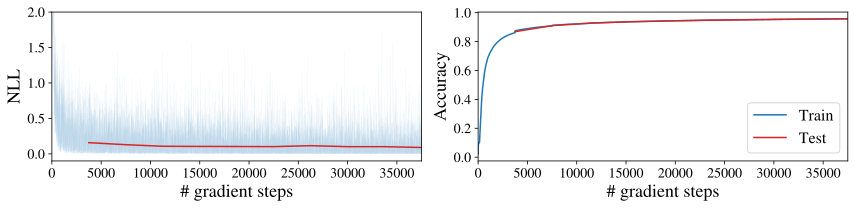

In [56]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats

set_matplotlib_formats('pdf', 'svg')

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

train_steps, train_nlls = zip(*all_train_losses)
_, train_accs = zip(*all_train_accuracies)
test_steps, test_nlls = zip(*all_test_losses)
_, test_accs = zip(*all_test_accuracies)

plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)
plt.plot(train_steps, train_nlls, color="tab:blue",linewidth=0.1, alpha=0.3)
plt.plot(test_steps, test_nlls, color="tab:red")
plt.ylim([-0.1, 2])
plt.xlim([0, train_steps[-1]])
plt.xlabel("# gradient steps", fontsize=18)
plt.ylabel("NLL", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.subplot(1, 2, 2)
plt.plot(train_steps, train_accs, color="tab:blue", label="Train")
plt.plot(test_steps, test_accs, color="tab:red", label="Test")
plt.xlim([0, train_steps[-1]])
plt.xlabel("# gradient steps", fontsize=18)
plt.ylabel("Accuracy", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.legend(loc="lower right", fontsize=16)
plt.tight_layout()
plt.show()

## Conclusion
We have looked at the details of the transformer architecture.
It consists of identical blocks, each of which contains a self-attention and a multi-layer perceptron operation, together with normalisation layers and residual connections.
Coupling these together with position embeddings and an appropriate tokenisation layer makes up the entire transformer architecture.
We looked at a specific example for computer vision, the ViT, and trained it on MNIST.

## References

```{bibliography}
:filter: docname in docnames
```